In [1]:
%matplotlib inline
import os
import zipfile
import torch
import torchvision
from torch import nn
from torchvision.datasets.utils import download_url
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [2]:
dataset_url = 'https://apache-mxnet.s3-accelerate.amazonaws.com/gluon/dataset/hotdog.zip'
data_path = '../data/Transfer_learning'
dataset = download_url(root=data_path, url=dataset_url)

Using downloaded and verified file: ../data/Transfer_learning/hotdog.zip


In [3]:
with zipfile.ZipFile(data_path+'/hotdog.zip', 'r') as zipf:
    zipf.extractall(path=data_path)

In [4]:
os.listdir(data_path+'/hotdog')

['train', 'test']

In [5]:
data_path +='/hotdog'

In [6]:
# Load train and test data
train_imgs = torchvision.datasets.ImageFolder(os.path.join(data_path,'train'))
test_imgs = torchvision.datasets.ImageFolder(os.path.join(data_path,'test'))

In [7]:
hot_dogs = [train_imgs[i][0] for i in range(8)]
non_hot_dogs = [train_imgs[-i-1][0] for i in range(8)]

In [8]:
def show_images(images, rows, cols, scale=1):
    fig, axes= plt.subplots(rows,cols, figsize=(cols * scale, rows * scale),
                             gridspec_kw={'wspace': 0.0, 'hspace': 0.0})
    for i in range(rows*cols):
        ax = axes[i//cols, i%cols]
        ax.imshow(images[i])
        ax.axis("off")
    plt.show()

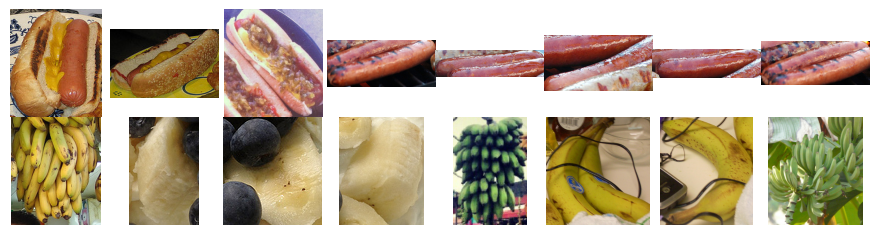

In [9]:
show_images(hot_dogs+non_hot_dogs,2,8, 1.4)

In [10]:
# Normalization
# Define mean and standard deviation of imagenet dataset 
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
normalize = torchvision.transforms.Normalize(mean, std)
# image augmentation
train_aug = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    normalize,
])
test_aug = torchvision.transforms.Compose([
    torchvision.transforms.Resize([256,256]),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    normalize,
])

In [11]:
# Defining the Model we use pretrained resnet-18 on imagenet dataset
pretrained_net = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1) 

In [12]:
pretrained_net.fc # output layer

Linear(in_features=512, out_features=1000, bias=True)

In [13]:
pretrained_net.fc = nn.Linear(pretrained_net.fc.in_features,2) # Change output to 2 

In [14]:
nn.init.xavier_uniform_(pretrained_net.fc.weight) # Initialize the new changed output' weights

Parameter containing:
tensor([[ 0.0329,  0.0401,  0.0904,  ..., -0.0828, -0.0887, -0.0943],
        [-0.0245,  0.0404,  0.0774,  ..., -0.0480, -0.0074, -0.0178]],
       requires_grad=True)

In [15]:
def train_batch(net, X, y, loss, trainer, devices):
    """Train for a minibatch with multiple GPUs"""
    if isinstance(X, list):
        X = [x.to(devices[0]) for x in X]
    else :
        X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    output = net(X)
    l = loss(output, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = (output.argmax(dim=1) == y).sum()
    return train_loss_sum, train_acc_sum
    
def train(net, train_iter, test_iter, loss, trainer, num_epochs, devices):
    net = nn.DataParallel(net, device_ids=devices).to(devices[0]) # transfer model to GPUs
    for epoch in range(num_epochs):
        metrics = [0.0,0.0]
        num_examples = 0
        for X, y in train_iter:
            train_loss_sum , train_acc_sum = train_batch(net, X, y, loss, trainer, devices)
            num_examples += y.shape[0]
            metrics[0] += train_loss_sum
            metrics[1] += train_acc_sum
            torch.cuda.empty_cache()
        train_loss = metrics[0]/num_examples
        train_acc = metrics[1]/num_examples
        test_acc = evaluate_accuracy(net, test_iter, devices)
        torch.cuda.empty_cache()
        print(f'Epoch {epoch + 1}, Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
def evaluate_accuracy(net, test_iter, devices):
    net.eval()
    metrics = [0.0, 0]
    for X, y in test_iter:
        X, y = X.to(devices[0]), y.to(devices[0])
        output = net(X)
        metrics[0] += (output.argmax(dim=1) == y).sum()
        metrics[1] += y.shape[0]
    return metrics[0]/metrics[1]

In [18]:
def train_fine_tuning(net, learning_rate, batch_size=128//4, num_epochs=5, param_group=True):
    train_imgs = torchvision.datasets.ImageFolder(os.path.join(data_path,'train'), transform = train_aug)
    test_imgs = torchvision.datasets.ImageFolder(os.path.join(data_path,'test'), transform = test_aug)
    train_iter = torch.utils.data.DataLoader(train_imgs, batch_size=batch_size, shuffle=True)
    test_iter = torch.utils.data.DataLoader(test_imgs, batch_size=batch_size)
    devices = [torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')]
    loss = nn.CrossEntropyLoss(reduction = 'none')
    
    if param_group :
        params_1x = [param for name, param in net.named_parameters()
                     if name not in ["fc.weight", "fc.bias"]]
        trainer = torch.optim.SGD([ {'params': params_1x},
                                    {'params': net.fc.parameters(),
                                    'lr': learning_rate * 10}],
                                    lr=learning_rate, weight_decay=0.001)
    else :
        trainer = torch.optim.SGD(net.parameters(), lr=learning_rate, weight_decay=0.001)
    train(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [19]:
train_fine_tuning(pretrained_net, 5e-5)

Epoch 1, Loss: 0.4672, Train Acc: 0.7903, Test Acc: 0.8750
Epoch 2, Loss: 0.2958, Train Acc: 0.8722, Test Acc: 0.9250
Epoch 3, Loss: 0.2213, Train Acc: 0.9141, Test Acc: 0.9250
Epoch 4, Loss: 0.2271, Train Acc: 0.9151, Test Acc: 0.9300
Epoch 5, Loss: 0.2149, Train Acc: 0.9131, Test Acc: 0.9137
